## FashionMNIST

## Setup

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from cifar10_models.resnet import resnet18 as resnet18_cifar10

In [15]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [16]:
train_np = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()

test_np = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

print(train_np.shape, train_labels.shape)
print(test_np.shape, test_labels.shape)
print(len(np.unique(train_labels)))

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
10


## Feature Extraction

In [17]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, visualize=False)
        hog_features.append(features)
        
    return np.array(hog_features)

train_hog = extract_hog_features(train_np)
test_hog = extract_hog_features(test_np)

print(train_hog.shape)

# ~58s

(60000, 1296)


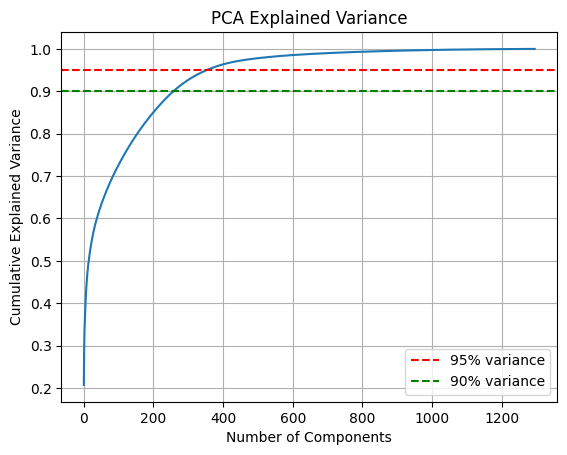

Number of components for 95% variance: 354
Number of components for 90% variance: 259


In [18]:
pca = PCA()
pca.fit(train_hog)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid()
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components for 95% variance: {n_components_95}")
print(f"Number of components for 90% variance: {n_components_90}")

# ~30s

In [19]:
n_components = n_components_95
pca = PCA(n_components=n_components)

train_pca = pca.fit_transform(train_hog)
test_pca = pca.transform(test_hog)

print(train_pca.shape, test_pca.shape)

# ~26s

(60000, 354) (10000, 354)


In [20]:
scaler = StandardScaler()
train_pca_scaled = scaler.fit_transform(train_pca)
test_pca_scaled = scaler.transform(test_pca)

print(f"Shape before selection: {train_pca_scaled.shape, test_pca_scaled.shape}")

Shape before selection: ((60000, 354), (10000, 354))


In [21]:
percentile = 18
selector_percentile = SelectPercentile(score_func=f_classif, percentile=percentile)
train_selected_percentile = selector_percentile.fit_transform(train_pca_scaled, train_labels)
test_selected_percentile = selector_percentile.transform(test_pca_scaled)

print(f"Shape after Select Percentile: {train_selected_percentile.shape, test_selected_percentile.shape}")

Shape after Select Percentile: ((60000, 64), (10000, 64))


In [22]:
def plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, title):

    max_train_accuracy = max(train_accuracies)
    max_test_accuracy = max(test_accuracies)
    max_train_epoch = train_accuracies.index(max_train_accuracy)
    max_test_epoch = test_accuracies.index(max_test_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='b')
    plt.plot(test_losses, label="Test Loss", color='r')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({title})")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color='b')
    plt.plot(test_accuracies, label="Test Accuracy", color='r')
    plt.scatter(max_train_epoch, max_train_accuracy, color='blue', label=f"Max Train Accuracy: {max_train_accuracy:.4f}", zorder=5)
    plt.scatter(max_test_epoch, max_test_accuracy, color='red', label=f"Max Test Accuracy: {max_test_accuracy:.4f}", zorder=5)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves ({title})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

## MLP over extracted features

In [23]:
X_train = torch.tensor(train_selected_percentile, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_selected_percentile, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [29]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
            #nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.model(x)
    
input_size = train_selected_percentile.shape[1]
num_classes = len(np.unique(train_labels))
model = MLP(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [30]:
num_epochs = 50
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch 1/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1009.11it/s]


Epoch 1/50, Train Loss: 0.6333, Test Loss: 0.3690, Train Acc: 0.7980, Test Acc: 0.8660


Epoch 2/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 983.88it/s]


Epoch 2/50, Train Loss: 0.3952, Test Loss: 0.3440, Train Acc: 0.8577, Test Acc: 0.8748


Epoch 3/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 711.09it/s]


Epoch 3/50, Train Loss: 0.3721, Test Loss: 0.3346, Train Acc: 0.8661, Test Acc: 0.8797


Epoch 4/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 974.68it/s]


Epoch 4/50, Train Loss: 0.3527, Test Loss: 0.3239, Train Acc: 0.8730, Test Acc: 0.8813


Epoch 5/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 762.78it/s]


Epoch 5/50, Train Loss: 0.3436, Test Loss: 0.3168, Train Acc: 0.8771, Test Acc: 0.8832


Epoch 6/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 792.14it/s]


Epoch 6/50, Train Loss: 0.3369, Test Loss: 0.3121, Train Acc: 0.8788, Test Acc: 0.8829


Epoch 7/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 887.73it/s]


Epoch 7/50, Train Loss: 0.3294, Test Loss: 0.3101, Train Acc: 0.8810, Test Acc: 0.8865


Epoch 8/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1079.02it/s]


Epoch 8/50, Train Loss: 0.3253, Test Loss: 0.3092, Train Acc: 0.8822, Test Acc: 0.8860


Epoch 9/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1045.94it/s]


Epoch 9/50, Train Loss: 0.3163, Test Loss: 0.3081, Train Acc: 0.8850, Test Acc: 0.8886


Epoch 10/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 999.96it/s]


Epoch 10/50, Train Loss: 0.3162, Test Loss: 0.3011, Train Acc: 0.8864, Test Acc: 0.8906


Epoch 11/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 838.83it/s]


Epoch 11/50, Train Loss: 0.3141, Test Loss: 0.3030, Train Acc: 0.8855, Test Acc: 0.8909


Epoch 12/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 970.41it/s]


Epoch 12/50, Train Loss: 0.3095, Test Loss: 0.3027, Train Acc: 0.8868, Test Acc: 0.8875


Epoch 13/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 941.31it/s]


Epoch 13/50, Train Loss: 0.3056, Test Loss: 0.2982, Train Acc: 0.8891, Test Acc: 0.8890


Epoch 14/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1070.88it/s]


Epoch 14/50, Train Loss: 0.3060, Test Loss: 0.2987, Train Acc: 0.8883, Test Acc: 0.8889


Epoch 15/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1015.58it/s]


Epoch 15/50, Train Loss: 0.3028, Test Loss: 0.2977, Train Acc: 0.8895, Test Acc: 0.8915


Epoch 16/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 780.95it/s]


Epoch 16/50, Train Loss: 0.2998, Test Loss: 0.3013, Train Acc: 0.8910, Test Acc: 0.8887


Epoch 17/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1070.89it/s]


Epoch 17/50, Train Loss: 0.2986, Test Loss: 0.2958, Train Acc: 0.8911, Test Acc: 0.8903


Epoch 18/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1011.89it/s]


Epoch 18/50, Train Loss: 0.2955, Test Loss: 0.3001, Train Acc: 0.8919, Test Acc: 0.8888


Epoch 19/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1057.64it/s]


Epoch 19/50, Train Loss: 0.2963, Test Loss: 0.2945, Train Acc: 0.8908, Test Acc: 0.8900


Epoch 20/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1042.51it/s]


Epoch 20/50, Train Loss: 0.2941, Test Loss: 0.2966, Train Acc: 0.8919, Test Acc: 0.8899


Epoch 21/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1028.89it/s]


Epoch 21/50, Train Loss: 0.2936, Test Loss: 0.2958, Train Acc: 0.8938, Test Acc: 0.8910


Epoch 22/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1063.65it/s]


Epoch 22/50, Train Loss: 0.2914, Test Loss: 0.2979, Train Acc: 0.8931, Test Acc: 0.8910


Epoch 23/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 749.62it/s]


Epoch 23/50, Train Loss: 0.2861, Test Loss: 0.2979, Train Acc: 0.8960, Test Acc: 0.8909


Epoch 24/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 844.70it/s]


Epoch 24/50, Train Loss: 0.2898, Test Loss: 0.2930, Train Acc: 0.8939, Test Acc: 0.8938


Epoch 25/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1028.87it/s]


Epoch 25/50, Train Loss: 0.2860, Test Loss: 0.2943, Train Acc: 0.8948, Test Acc: 0.8932


Epoch 26/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 969.69it/s]


Epoch 26/50, Train Loss: 0.2863, Test Loss: 0.2951, Train Acc: 0.8941, Test Acc: 0.8921


Epoch 27/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1064.73it/s]


Epoch 27/50, Train Loss: 0.2872, Test Loss: 0.2922, Train Acc: 0.8944, Test Acc: 0.8911


Epoch 28/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1132.38it/s]


Epoch 28/50, Train Loss: 0.2836, Test Loss: 0.2931, Train Acc: 0.8966, Test Acc: 0.8917


Epoch 29/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 945.43it/s]


Epoch 29/50, Train Loss: 0.2852, Test Loss: 0.2940, Train Acc: 0.8948, Test Acc: 0.8924


Epoch 30/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1025.49it/s]


Epoch 30/50, Train Loss: 0.2827, Test Loss: 0.2949, Train Acc: 0.8962, Test Acc: 0.8911


Epoch 31/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1049.47it/s]


Epoch 31/50, Train Loss: 0.2792, Test Loss: 0.2931, Train Acc: 0.8967, Test Acc: 0.8936


Epoch 32/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1055.42it/s]


Epoch 32/50, Train Loss: 0.2808, Test Loss: 0.2962, Train Acc: 0.8968, Test Acc: 0.8910


Epoch 33/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1026.38it/s]


Epoch 33/50, Train Loss: 0.2779, Test Loss: 0.2971, Train Acc: 0.8957, Test Acc: 0.8931


Epoch 34/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1061.13it/s]


Epoch 34/50, Train Loss: 0.2799, Test Loss: 0.2944, Train Acc: 0.8970, Test Acc: 0.8919


Epoch 35/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 491.91it/s]


Epoch 35/50, Train Loss: 0.2798, Test Loss: 0.2965, Train Acc: 0.8971, Test Acc: 0.8914


Epoch 36/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 878.56it/s]


Epoch 36/50, Train Loss: 0.2760, Test Loss: 0.2978, Train Acc: 0.8982, Test Acc: 0.8909


Epoch 37/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 965.77it/s]


Epoch 37/50, Train Loss: 0.2778, Test Loss: 0.2952, Train Acc: 0.8962, Test Acc: 0.8944


Epoch 38/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 965.77it/s]


Epoch 38/50, Train Loss: 0.2744, Test Loss: 0.3015, Train Acc: 0.8988, Test Acc: 0.8901


Epoch 39/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 993.46it/s]


Epoch 39/50, Train Loss: 0.2769, Test Loss: 0.2959, Train Acc: 0.8971, Test Acc: 0.8926


Epoch 40/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 837.39it/s]


Epoch 40/50, Train Loss: 0.2753, Test Loss: 0.2985, Train Acc: 0.8984, Test Acc: 0.8915


Epoch 41/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 983.88it/s]


Epoch 41/50, Train Loss: 0.2752, Test Loss: 0.2965, Train Acc: 0.8978, Test Acc: 0.8907


Epoch 42/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 896.93it/s]


Epoch 42/50, Train Loss: 0.2735, Test Loss: 0.2945, Train Acc: 0.8997, Test Acc: 0.8930


Epoch 43/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 942.64it/s]


Epoch 43/50, Train Loss: 0.2742, Test Loss: 0.2940, Train Acc: 0.8989, Test Acc: 0.8934


Epoch 44/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1148.93it/s]


Epoch 44/50, Train Loss: 0.2716, Test Loss: 0.3000, Train Acc: 0.8990, Test Acc: 0.8913


Epoch 45/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1120.38it/s]


Epoch 45/50, Train Loss: 0.2728, Test Loss: 0.2972, Train Acc: 0.8995, Test Acc: 0.8921


Epoch 46/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1345.17it/s]


Epoch 46/50, Train Loss: 0.2721, Test Loss: 0.3009, Train Acc: 0.8991, Test Acc: 0.8885


Epoch 47/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1132.52it/s]


Epoch 47/50, Train Loss: 0.2712, Test Loss: 0.3013, Train Acc: 0.8989, Test Acc: 0.8883


Epoch 48/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1116.47it/s]


Epoch 48/50, Train Loss: 0.2715, Test Loss: 0.3005, Train Acc: 0.8992, Test Acc: 0.8920


Epoch 49/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1266.41it/s]


Epoch 49/50, Train Loss: 0.2709, Test Loss: 0.2991, Train Acc: 0.9002, Test Acc: 0.8924


Epoch 50/50 Testing: 100%|██████████| 157/157 [00:00<00:00, 1113.05it/s]

Epoch 50/50, Train Loss: 0.2699, Test Loss: 0.2978, Train Acc: 0.8990, Test Acc: 0.8920


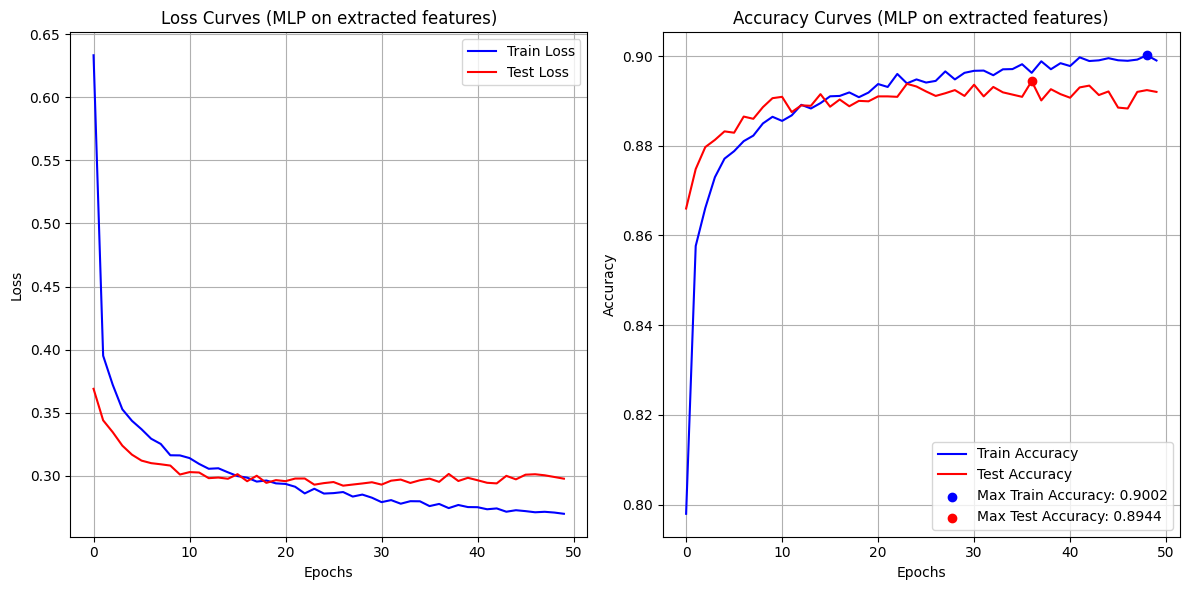

In [31]:
plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, "MLP on extracted features")

## MLP directly on images 

In [32]:
train_images_flattened = train_np.reshape(train_np.shape[0], -1).astype(np.float32)
test_images_flattened = test_np.reshape(test_np.shape[0], -1).astype(np.float32)

scaler = StandardScaler()
train_images_normalized = scaler.fit_transform(train_images_flattened)
test_images_normalized = scaler.transform(test_images_flattened)

X_train = torch.tensor(train_images_normalized, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_test = torch.tensor(test_images_normalized, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [65]:
class MLPImage(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPImage, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.model(x)


input_size = train_images_normalized.shape[1]
num_classes = len(np.unique(train_labels))

model = MLPImage(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
num_epochs = 30
train_losses, test_losses, train_accuracies, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs
)

Epoch 1/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 584.10it/s]


Epoch 1/30, Train Loss: 0.5565, Test Loss: 0.4144, Train Acc: 0.8019, Test Acc: 0.8489


Epoch 2/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 857.83it/s]


Epoch 2/30, Train Loss: 0.4196, Test Loss: 0.3814, Train Acc: 0.8511, Test Acc: 0.8636


Epoch 3/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 844.02it/s]


Epoch 3/30, Train Loss: 0.3935, Test Loss: 0.3647, Train Acc: 0.8607, Test Acc: 0.8657


Epoch 4/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 841.82it/s]


Epoch 4/30, Train Loss: 0.3695, Test Loss: 0.3557, Train Acc: 0.8682, Test Acc: 0.8683


Epoch 5/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 815.55it/s]


Epoch 5/30, Train Loss: 0.3555, Test Loss: 0.3444, Train Acc: 0.8716, Test Acc: 0.8728


Epoch 6/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 899.55it/s]


Epoch 6/30, Train Loss: 0.3459, Test Loss: 0.3457, Train Acc: 0.8742, Test Acc: 0.8751


Epoch 7/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 887.07it/s]


Epoch 7/30, Train Loss: 0.3368, Test Loss: 0.3455, Train Acc: 0.8781, Test Acc: 0.8747


Epoch 8/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 872.08it/s]


Epoch 8/30, Train Loss: 0.3269, Test Loss: 0.3370, Train Acc: 0.8816, Test Acc: 0.8758


Epoch 9/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 832.67it/s]


Epoch 9/30, Train Loss: 0.3195, Test Loss: 0.3558, Train Acc: 0.8826, Test Acc: 0.8735


Epoch 10/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 844.01it/s]


Epoch 10/30, Train Loss: 0.3174, Test Loss: 0.3476, Train Acc: 0.8833, Test Acc: 0.8736


Epoch 11/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 912.52it/s]


Epoch 11/30, Train Loss: 0.3081, Test Loss: 0.3393, Train Acc: 0.8869, Test Acc: 0.8804


Epoch 12/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 822.42it/s]


Epoch 12/30, Train Loss: 0.3026, Test Loss: 0.3431, Train Acc: 0.8883, Test Acc: 0.8798


Epoch 13/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 781.22it/s]


Epoch 13/30, Train Loss: 0.2960, Test Loss: 0.3398, Train Acc: 0.8902, Test Acc: 0.8775


Epoch 14/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 791.05it/s]


Epoch 14/30, Train Loss: 0.2947, Test Loss: 0.3401, Train Acc: 0.8924, Test Acc: 0.8779


Epoch 15/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 821.88it/s]


Epoch 15/30, Train Loss: 0.2891, Test Loss: 0.3358, Train Acc: 0.8944, Test Acc: 0.8819


Epoch 16/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 886.84it/s]


Epoch 16/30, Train Loss: 0.2836, Test Loss: 0.3356, Train Acc: 0.8957, Test Acc: 0.8814


Epoch 17/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 795.04it/s]


Epoch 17/30, Train Loss: 0.2808, Test Loss: 0.3303, Train Acc: 0.8965, Test Acc: 0.8821


Epoch 18/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 915.23it/s]


Epoch 18/30, Train Loss: 0.2777, Test Loss: 0.3291, Train Acc: 0.8964, Test Acc: 0.8851


Epoch 19/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 870.65it/s]


Epoch 19/30, Train Loss: 0.2760, Test Loss: 0.3314, Train Acc: 0.8988, Test Acc: 0.8816


Epoch 20/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 857.83it/s]


Epoch 20/30, Train Loss: 0.2704, Test Loss: 0.3260, Train Acc: 0.9006, Test Acc: 0.8886


Epoch 21/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 805.31it/s]


Epoch 21/30, Train Loss: 0.2676, Test Loss: 0.3472, Train Acc: 0.9021, Test Acc: 0.8860


Epoch 22/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 915.24it/s]


Epoch 22/30, Train Loss: 0.2667, Test Loss: 0.3393, Train Acc: 0.9012, Test Acc: 0.8801


Epoch 23/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 837.34it/s]


Epoch 23/30, Train Loss: 0.2638, Test Loss: 0.3308, Train Acc: 0.9021, Test Acc: 0.8831


Epoch 24/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 737.30it/s]


Epoch 24/30, Train Loss: 0.2614, Test Loss: 0.3349, Train Acc: 0.9036, Test Acc: 0.8864


Epoch 25/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 730.29it/s]


Epoch 25/30, Train Loss: 0.2601, Test Loss: 0.3414, Train Acc: 0.9025, Test Acc: 0.8843


Epoch 26/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 807.20it/s]


Epoch 26/30, Train Loss: 0.2597, Test Loss: 0.3385, Train Acc: 0.9044, Test Acc: 0.8877


Epoch 27/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 884.27it/s]


Epoch 27/30, Train Loss: 0.2501, Test Loss: 0.3343, Train Acc: 0.9068, Test Acc: 0.8837


Epoch 28/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 920.59it/s]


Epoch 28/30, Train Loss: 0.2519, Test Loss: 0.3399, Train Acc: 0.9063, Test Acc: 0.8851


Epoch 29/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 796.96it/s]


Epoch 29/30, Train Loss: 0.2498, Test Loss: 0.3356, Train Acc: 0.9068, Test Acc: 0.8881


Epoch 30/30 Testing: 100%|██████████| 157/157 [00:00<00:00, 884.12it/s]

Epoch 30/30, Train Loss: 0.2465, Test Loss: 0.3325, Train Acc: 0.9080, Test Acc: 0.8913


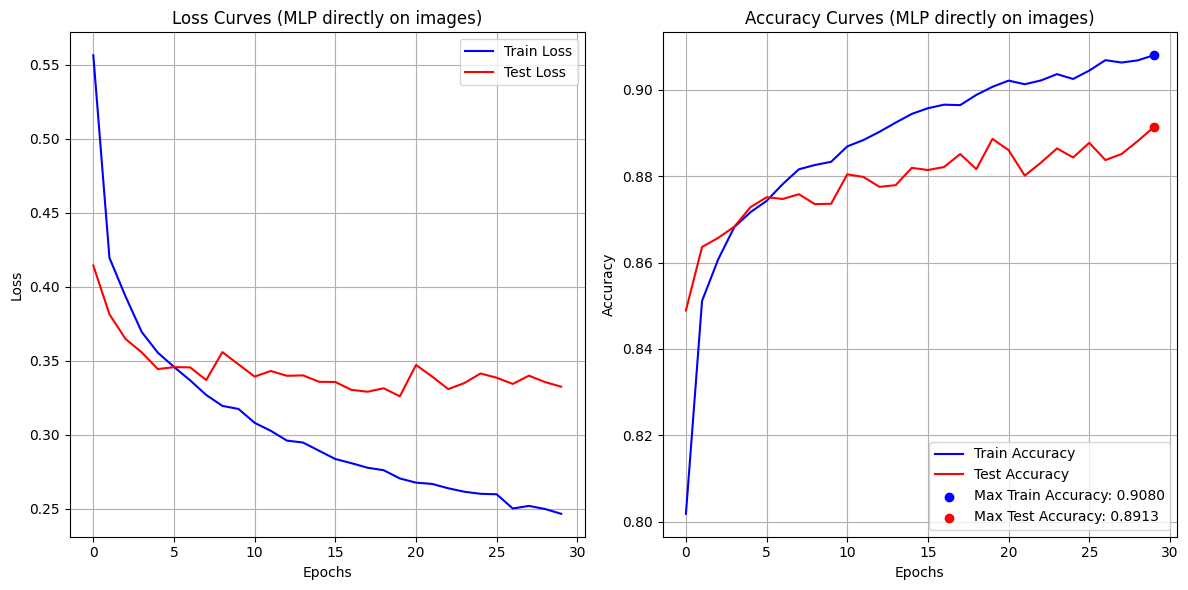

In [67]:
plot_accuracies_and_losses(train_losses, test_losses, train_accuracies, test_accuracies, "MLP directly on images")

## CNN

60000 60000 10000
torch.Size([1, 28, 28]) torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


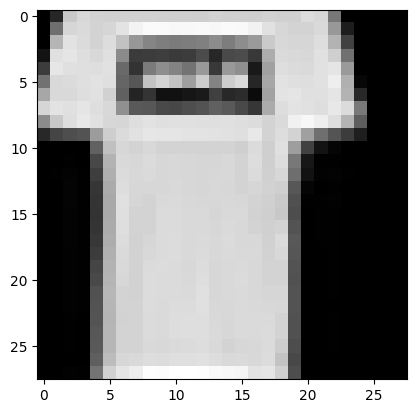

In [68]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
train_dataset_augmented = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform_augmented)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


print(len(train_dataset), len(train_dataset_augmented), len(test_dataset))
print(train_loader.dataset[0][0].shape, train_loader_augmented.dataset[0][0].shape, test_loader.dataset[0][0].shape)
plt.imshow(train_dataset_augmented[1][0].squeeze(), cmap='gray')

In [69]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1x28x28, Output: 32x28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 32x14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64x14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # Output: 64x7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# Output: 128x7x7
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Global Average Pooling
        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Output: 128x1x1
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                # Output: 128
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pooling(x)
        x = self.fc_layers(x)
        return x
    
model = CNN(num_classes=len(np.unique(train_labels)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
num_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)

cuda


In [70]:
def train_cnn(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [71]:
# Train with unaugmented images
train_losses_no_aug, test_losses_no_aug, train_accuracies_no_aug, test_accuracies_no_aug = train_cnn(
    model, train_loader, test_loader, criterion, optimizer, num_epochs, device
)

Epoch 1/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 110.39it/s]


Epoch 1/30, Train Loss: 0.8218, Test Loss: 0.5797, Train Acc: 0.7228, Test Acc: 0.7849


Epoch 2/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 80.60it/s]


Epoch 2/30, Train Loss: 0.4612, Test Loss: 0.4293, Train Acc: 0.8401, Test Acc: 0.8435


Epoch 3/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.94it/s]


Epoch 3/30, Train Loss: 0.3946, Test Loss: 0.4322, Train Acc: 0.8612, Test Acc: 0.8432


Epoch 4/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.22it/s]


Epoch 4/30, Train Loss: 0.3616, Test Loss: 0.3772, Train Acc: 0.8729, Test Acc: 0.8608


Epoch 5/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.04it/s]


Epoch 5/30, Train Loss: 0.3352, Test Loss: 0.3803, Train Acc: 0.8833, Test Acc: 0.8645


Epoch 6/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 113.58it/s]


Epoch 6/30, Train Loss: 0.3158, Test Loss: 0.3303, Train Acc: 0.8882, Test Acc: 0.8809


Epoch 7/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 122.76it/s]


Epoch 7/30, Train Loss: 0.2998, Test Loss: 0.3045, Train Acc: 0.8944, Test Acc: 0.8899


Epoch 8/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 121.98it/s]


Epoch 8/30, Train Loss: 0.2872, Test Loss: 0.3534, Train Acc: 0.8983, Test Acc: 0.8708


Epoch 9/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 122.11it/s]


Epoch 9/30, Train Loss: 0.2774, Test Loss: 0.3147, Train Acc: 0.9032, Test Acc: 0.8881


Epoch 10/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 73.99it/s]


Epoch 10/30, Train Loss: 0.2696, Test Loss: 0.3958, Train Acc: 0.9060, Test Acc: 0.8582


Epoch 11/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.28it/s]


Epoch 11/30, Train Loss: 0.2565, Test Loss: 0.3161, Train Acc: 0.9089, Test Acc: 0.8900


Epoch 12/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.64it/s]


Epoch 12/30, Train Loss: 0.2496, Test Loss: 0.2791, Train Acc: 0.9116, Test Acc: 0.8997


Epoch 13/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.61it/s]


Epoch 13/30, Train Loss: 0.2431, Test Loss: 0.3040, Train Acc: 0.9146, Test Acc: 0.8956


Epoch 14/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 115.24it/s]


Epoch 14/30, Train Loss: 0.2348, Test Loss: 0.3645, Train Acc: 0.9171, Test Acc: 0.8646


Epoch 15/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 115.92it/s]


Epoch 15/30, Train Loss: 0.2277, Test Loss: 0.3815, Train Acc: 0.9196, Test Acc: 0.8670


Epoch 16/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 119.21it/s]


Epoch 16/30, Train Loss: 0.2224, Test Loss: 0.2843, Train Acc: 0.9211, Test Acc: 0.9026


Epoch 17/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.50it/s]


Epoch 17/30, Train Loss: 0.2152, Test Loss: 0.3299, Train Acc: 0.9248, Test Acc: 0.8847


Epoch 18/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.11it/s]


Epoch 18/30, Train Loss: 0.2131, Test Loss: 0.3126, Train Acc: 0.9243, Test Acc: 0.8916


Epoch 19/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.04it/s]


Epoch 19/30, Train Loss: 0.2043, Test Loss: 0.3395, Train Acc: 0.9277, Test Acc: 0.8841


Epoch 20/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.07it/s]


Epoch 20/30, Train Loss: 0.2022, Test Loss: 0.2776, Train Acc: 0.9282, Test Acc: 0.9038


Epoch 21/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.21it/s]


Epoch 21/30, Train Loss: 0.1977, Test Loss: 0.2556, Train Acc: 0.9300, Test Acc: 0.9102


Epoch 22/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.95it/s]


Epoch 22/30, Train Loss: 0.1931, Test Loss: 0.2757, Train Acc: 0.9322, Test Acc: 0.9034


Epoch 23/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.09it/s]


Epoch 23/30, Train Loss: 0.1869, Test Loss: 0.3199, Train Acc: 0.9338, Test Acc: 0.8903


Epoch 24/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.26it/s]


Epoch 24/30, Train Loss: 0.1848, Test Loss: 0.2614, Train Acc: 0.9347, Test Acc: 0.9086


Epoch 25/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.43it/s]


Epoch 25/30, Train Loss: 0.1803, Test Loss: 0.3312, Train Acc: 0.9363, Test Acc: 0.8889


Epoch 26/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.43it/s]


Epoch 26/30, Train Loss: 0.1717, Test Loss: 0.6054, Train Acc: 0.9390, Test Acc: 0.8090


Epoch 27/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.01it/s]


Epoch 27/30, Train Loss: 0.1722, Test Loss: 0.2899, Train Acc: 0.9390, Test Acc: 0.9000


Epoch 28/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.42it/s]


Epoch 28/30, Train Loss: 0.1656, Test Loss: 0.2855, Train Acc: 0.9424, Test Acc: 0.9005


Epoch 29/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.22it/s]


Epoch 29/30, Train Loss: 0.1599, Test Loss: 0.2796, Train Acc: 0.9433, Test Acc: 0.9050


Epoch 30/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 116.16it/s]

Epoch 30/30, Train Loss: 0.1577, Test Loss: 0.2519, Train Acc: 0.9433, Test Acc: 0.9118


In [72]:
# Train with augmented images

model_aug = CNN(num_classes=len(np.unique(train_labels)))
model_aug = model_aug.to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)


train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug = train_cnn(
    model_aug, train_loader_augmented, test_loader, criterion, optimizer_aug, num_epochs, device
)

Epoch 1/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 76.01it/s]


Epoch 1/30, Train Loss: 0.7899, Test Loss: 0.4961, Train Acc: 0.7087, Test Acc: 0.8135


Epoch 2/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 72.34it/s]


Epoch 2/30, Train Loss: 0.5355, Test Loss: 0.5550, Train Acc: 0.8036, Test Acc: 0.7926


Epoch 3/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 74.39it/s]


Epoch 3/30, Train Loss: 0.4770, Test Loss: 0.4636, Train Acc: 0.8274, Test Acc: 0.8210


Epoch 4/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 74.82it/s]


Epoch 4/30, Train Loss: 0.4419, Test Loss: 0.4225, Train Acc: 0.8413, Test Acc: 0.8404


Epoch 5/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 74.84it/s]


Epoch 5/30, Train Loss: 0.4103, Test Loss: 0.4015, Train Acc: 0.8525, Test Acc: 0.8553


Epoch 6/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 74.11it/s]


Epoch 6/30, Train Loss: 0.3905, Test Loss: 0.3443, Train Acc: 0.8572, Test Acc: 0.8761


Epoch 7/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 72.15it/s]


Epoch 7/30, Train Loss: 0.3797, Test Loss: 0.3651, Train Acc: 0.8625, Test Acc: 0.8658


Epoch 8/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 75.33it/s]


Epoch 8/30, Train Loss: 0.3635, Test Loss: 0.3874, Train Acc: 0.8690, Test Acc: 0.8591


Epoch 9/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 88.99it/s] 


Epoch 9/30, Train Loss: 0.3555, Test Loss: 0.3421, Train Acc: 0.8726, Test Acc: 0.8781


Epoch 10/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 73.78it/s]


Epoch 10/30, Train Loss: 0.3464, Test Loss: 0.3336, Train Acc: 0.8741, Test Acc: 0.8861


Epoch 11/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.13it/s]


Epoch 11/30, Train Loss: 0.3409, Test Loss: 0.2959, Train Acc: 0.8770, Test Acc: 0.8915


Epoch 12/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 112.12it/s]


Epoch 12/30, Train Loss: 0.3273, Test Loss: 0.2907, Train Acc: 0.8814, Test Acc: 0.8955


Epoch 13/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 100.83it/s]


Epoch 13/30, Train Loss: 0.3230, Test Loss: 0.2938, Train Acc: 0.8829, Test Acc: 0.8949


Epoch 14/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 101.10it/s]


Epoch 14/30, Train Loss: 0.3196, Test Loss: 0.2911, Train Acc: 0.8851, Test Acc: 0.8985


Epoch 15/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 106.91it/s]


Epoch 15/30, Train Loss: 0.3116, Test Loss: 0.2679, Train Acc: 0.8869, Test Acc: 0.9016


Epoch 16/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 98.14it/s] 


Epoch 16/30, Train Loss: 0.3120, Test Loss: 0.2842, Train Acc: 0.8876, Test Acc: 0.8944


Epoch 17/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 115.83it/s]


Epoch 17/30, Train Loss: 0.3040, Test Loss: 0.2795, Train Acc: 0.8888, Test Acc: 0.8971


Epoch 18/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 91.62it/s] 


Epoch 18/30, Train Loss: 0.3008, Test Loss: 0.2686, Train Acc: 0.8911, Test Acc: 0.9038


Epoch 19/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 113.22it/s]


Epoch 19/30, Train Loss: 0.2949, Test Loss: 0.2549, Train Acc: 0.8933, Test Acc: 0.9081


Epoch 20/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 68.12it/s]


Epoch 20/30, Train Loss: 0.2942, Test Loss: 0.2594, Train Acc: 0.8933, Test Acc: 0.9086


Epoch 21/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 68.14it/s]


Epoch 21/30, Train Loss: 0.2908, Test Loss: 0.2512, Train Acc: 0.8960, Test Acc: 0.9088


Epoch 22/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 70.29it/s]


Epoch 22/30, Train Loss: 0.2875, Test Loss: 0.2988, Train Acc: 0.8962, Test Acc: 0.8874


Epoch 23/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 69.59it/s]


Epoch 23/30, Train Loss: 0.2823, Test Loss: 0.2637, Train Acc: 0.8971, Test Acc: 0.9025


Epoch 24/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 90.25it/s]


Epoch 24/30, Train Loss: 0.2799, Test Loss: 0.2427, Train Acc: 0.8983, Test Acc: 0.9109


Epoch 25/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 111.79it/s]


Epoch 25/30, Train Loss: 0.2795, Test Loss: 0.2415, Train Acc: 0.8980, Test Acc: 0.9121


Epoch 26/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 109.78it/s]


Epoch 26/30, Train Loss: 0.2772, Test Loss: 0.2544, Train Acc: 0.8992, Test Acc: 0.9093


Epoch 27/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 112.24it/s]


Epoch 27/30, Train Loss: 0.2747, Test Loss: 0.2442, Train Acc: 0.8998, Test Acc: 0.9102


Epoch 28/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 111.10it/s]


Epoch 28/30, Train Loss: 0.2719, Test Loss: 0.2415, Train Acc: 0.9017, Test Acc: 0.9113


Epoch 29/30 Testing: 100%|██████████| 157/157 [00:01<00:00, 117.22it/s]


Epoch 29/30, Train Loss: 0.2674, Test Loss: 0.2476, Train Acc: 0.9024, Test Acc: 0.9126


Epoch 30/30 Testing: 100%|██████████| 157/157 [00:02<00:00, 61.05it/s]

Epoch 30/30, Train Loss: 0.2663, Test Loss: 0.2267, Train Acc: 0.9028, Test Acc: 0.9201


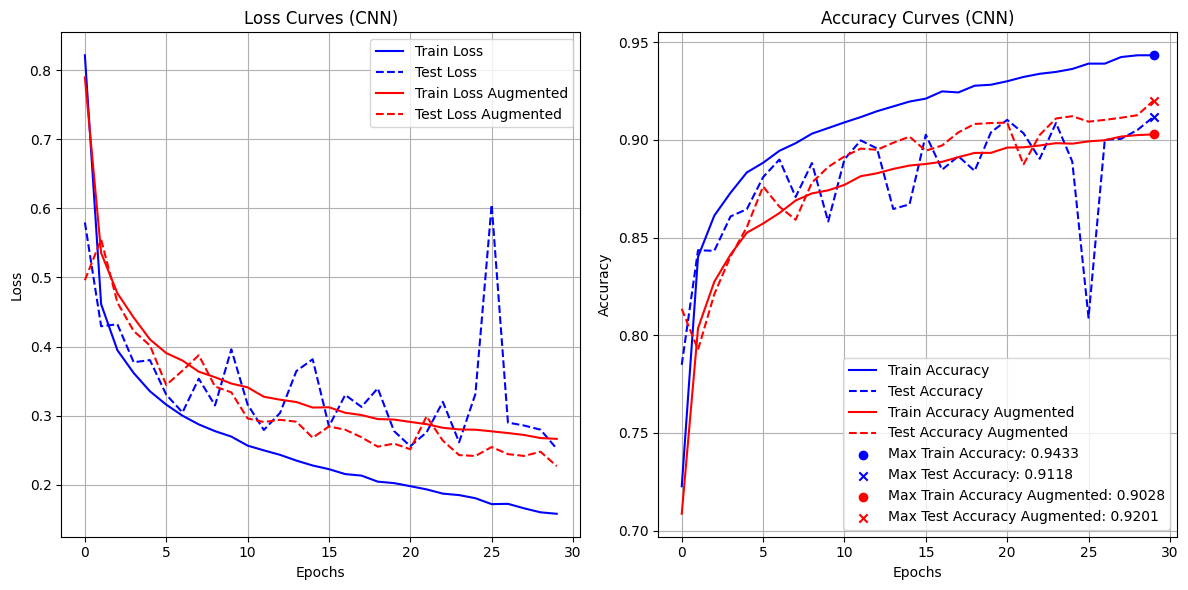

In [73]:
def plot_accuracies_and_losses_2(train_losses, test_losses, train_accuracies, test_accuracies,
                                 train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug, title):
    
    max_train_accuracy = max(train_accuracies)
    max_test_accuracy = max(test_accuracies)
    max_train_epoch = train_accuracies.index(max_train_accuracy)
    max_test_epoch = test_accuracies.index(max_test_accuracy)

    max_train_accuracy_aug = max(train_accuracies_aug)
    max_test_accuracy_aug = max(test_accuracies_aug)
    max_train_epoch_aug = train_accuracies_aug.index(max_train_accuracy_aug)
    max_test_epoch_aug = test_accuracies_aug.index(max_test_accuracy_aug)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)

    plt.plot(train_losses, label="Train Loss", color='b')
    plt.plot(test_losses, label="Test Loss", color='b', linestyle='--')
    plt.plot(train_losses_aug, label="Train Loss Augmented", color='r')
    plt.plot(test_losses_aug, label="Test Loss Augmented", color='r', linestyle='--')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves ({title})")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)

    plt.plot(train_accuracies, label="Train Accuracy", color='b')
    plt.plot(test_accuracies, label="Test Accuracy", color='b', linestyle='--')
    plt.plot(train_accuracies_aug, label="Train Accuracy Augmented", color='r')
    plt.plot(test_accuracies_aug, label="Test Accuracy Augmented", color='r', linestyle='--')

    plt.scatter(max_train_epoch, max_train_accuracy, color='blue', label=f"Max Train Accuracy: {max_train_accuracy:.4f}", zorder=5)
    plt.scatter(max_test_epoch, max_test_accuracy, color='blue', label=f"Max Test Accuracy: {max_test_accuracy:.4f}", zorder=5, marker='x')
    plt.scatter(max_train_epoch_aug, max_train_accuracy_aug, color='red', label=f"Max Train Accuracy Augmented: {max_train_accuracy_aug:.4f}", zorder=5)
    plt.scatter(max_test_epoch_aug, max_test_accuracy_aug, color='red', label=f"Max Test Accuracy Augmented: {max_test_accuracy_aug:.4f}", zorder=5, marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy Curves ({title})")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


plot_accuracies_and_losses_2(train_losses_no_aug, test_losses_no_aug, train_accuracies_no_aug, test_accuracies_no_aug,
                                train_losses_aug, test_losses_aug, train_accuracies_aug, test_accuracies_aug, "CNN")

## Fine-tuning ResNet-18

In [74]:
train_transform_resnet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

test_transform_resnet = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2471, 0.2435, 0.2616])
])

train_dataset_resnet = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform_resnet)
test_dataset_resnet = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=64, shuffle=True)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=64, shuffle=False)

In [75]:
model_resnet18 = resnet18_cifar10(pretrained=True)

num_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_features, len(np.unique(train_labels)))

model_resnet18.fc = nn.Sequential(
    #nn.Linear(num_features, 128),
    #nn.ReLU(),
    #nn.Dropout(0.5),
    nn.Linear(num_features, len(np.unique(train_labels)))
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet18 = model_resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.SGD(model_resnet18.parameters(), lr=0.0005, momentum=0.9)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=5, gamma=0.1)


c:\Users\Alex\Documents\GitHub\invatare-automata\tema2-image-classification\cifar10_models\resnet.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

In [76]:
def train_resnet(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct = 0, 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=True)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()

            train_bar.set_postfix(loss=loss.item())

            

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / len(train_loader.dataset))

        scheduler.step()

        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} Testing", leave=True)
            for X_batch, y_batch in test_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                test_correct += (outputs.argmax(dim=1) == y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_correct / len(test_loader.dataset))

        

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Acc: {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [77]:
num_epochs = 10
train_losses_resnet, test_losses_resnet, train_accuracies_resnet, test_accuracies_resnet = train_resnet(
    model_resnet18, train_loader_resnet, test_loader_resnet, criterion, optimizer_resnet, scheduler_resnet, num_epochs, device
)

Epoch 1/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 33.17it/s]


Epoch 1/10, Train Loss: 0.7480, Test Loss: 0.3288, Train Acc: 0.8300, Test Acc: 0.9062


Epoch 2/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 33.09it/s]


Epoch 2/10, Train Loss: 0.2753, Test Loss: 0.2404, Train Acc: 0.9188, Test Acc: 0.9232


Epoch 3/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 37.42it/s]


Epoch 3/10, Train Loss: 0.2082, Test Loss: 0.2364, Train Acc: 0.9350, Test Acc: 0.9208


Epoch 4/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 36.59it/s]


Epoch 4/10, Train Loss: 0.1744, Test Loss: 0.2232, Train Acc: 0.9440, Test Acc: 0.9246


Epoch 5/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 37.10it/s]


Epoch 5/10, Train Loss: 0.1492, Test Loss: 0.2141, Train Acc: 0.9515, Test Acc: 0.9281


Epoch 6/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 35.87it/s]


Epoch 6/10, Train Loss: 0.0917, Test Loss: 0.1837, Train Acc: 0.9730, Test Acc: 0.9418


Epoch 7/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 38.25it/s]


Epoch 7/10, Train Loss: 0.0742, Test Loss: 0.1893, Train Acc: 0.9800, Test Acc: 0.9412


Epoch 8/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 37.05it/s]


Epoch 8/10, Train Loss: 0.0626, Test Loss: 0.1937, Train Acc: 0.9841, Test Acc: 0.9402


Epoch 9/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 38.38it/s]


Epoch 9/10, Train Loss: 0.0542, Test Loss: 0.1994, Train Acc: 0.9872, Test Acc: 0.9399


Epoch 10/10 Testing: 100%|██████████| 157/157 [00:04<00:00, 37.42it/s]

Epoch 10/10, Train Loss: 0.0461, Test Loss: 0.2051, Train Acc: 0.9897, Test Acc: 0.9409


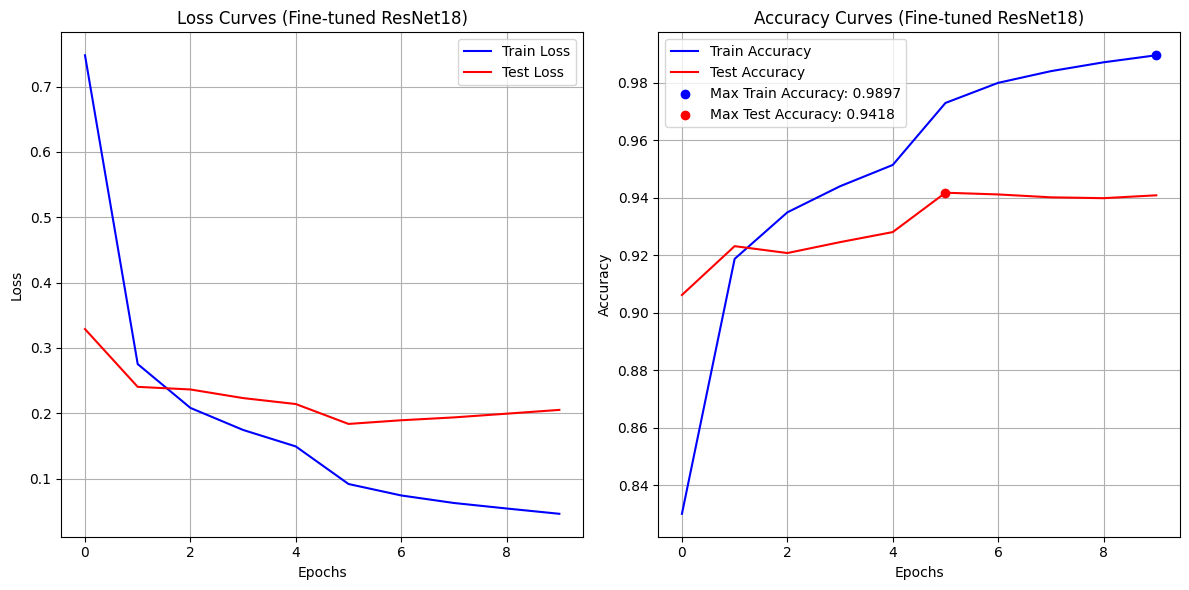

In [78]:
plot_accuracies_and_losses(train_losses_resnet, test_losses_resnet, train_accuracies_resnet, test_accuracies_resnet, "Fine-tuned ResNet18")